# 1) Normalize the matrix 
* Does the matrix need to be symmetric?
* Should beads get normalized in some way?
* Should we regularize the edges of the graph?

# 2) An inital guess
* Make an MDS based initial guess of the position of each bead in the array
* Could minimize a stress function? <-- look up what this is 
### Implementation
* What's a good MDS package?
  1. [Scikit-learn MDS](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html)
  * Does not work on sparse Matrices  
* How much memory is neede to run on a large matrix?
  1. If the matrix is 50K * 50K elements, a dense matrix of u16 ints will be 5GB
* Are there implementations that work on sparse matrix format?



# 3) Write a score function for a guess
* Place beads on a 2D euclidean plane
* For each bead pair observed in the real data, calculate the euclidean distance between that pair of beads in the proposed solution
* The data is in a form where stronger edge weights mean that beads are closer together
* Write a function that has a minima when the beads are closest



In [3]:
# %pip install scikit-learn
# %pip install gitpython

import git, os, sys
import numpy as np
import scipy as sp
from plotnine import *
import pandas as pd

"""
Check if a file is downloaded. If it is not, download it.
"""
def download_file(url, filename):
    if not os.path.isfile(filename):
        print("Downloading file from", url)
        urllib.request.urlretrieve(url, filename)

def get_git_root(path):

        git_repo = git.Repo(path, search_parent_directories=True)
        git_root = git_repo.git.rev_parse("--show-toplevel")
        return git_root
        


In [4]:
"""
Write a function that takes as input a matrix of scores and a list of configurations and returns the best configuration.
"""
def get_best_configuration(scores, configurations):
    best_config = configurations[np.argmax(scores)]
    return best_config


In [150]:
def make_random_configuration(data_matrix):
    ''''
    Place all the beads in a random configuration.
    To do this I am going to take an ideal matrix of positions and randomly assign beads to those positions.
    Initially this is just going to be a grid of positions at the moment we just want something random that we can score
    '''

    # Get the number of beads in the matrix
    num_beads = data_matrix.shape[0]
    # Use the square root of this number to make a square with this many positions
    num_positions = int(np.ceil(np.sqrt(num_beads)))
    empty_matrix = np.zeros((num_positions, num_positions))
    print(f'There are {num_beads} beads and we are placing them in a {num_positions} * {num_positions} grid')
    # Create a list of randomly sorted beads
    beads = np.arange(num_beads)
    np.random.shuffle(beads)
    # Calculate the number of empty positions
    num_empty_positions = num_positions**2 - num_beads
    # Pad the positions with zeros so that we can just reshape into a square matrix
    beads = np.pad(beads, (0, num_empty_positions), 'constant', constant_values=(0,-1))
    # Reshape the list of beads into a square matrix
    position_matrix = np.reshape(beads, (num_positions, num_positions))
    print(position_matrix.shape)
    
    return position_matrix

def position_matrix_to_df(position_matrix):
    '''
    take in the poistion matrix and output a bead index sorted dataframe with the x and y positions
    Bead index 1 will be the first bead in the matrix with the two columns specifying the x and y positions
    '''
    # Turn the matrix into a dataframe with the x and y positions
    # Add 1 so that we don't lose the zeros when we convert to a sparse matrix
    # As a bonus we lose the -1s that we added to the end of the matrix
    sparse_matrix = sp.sparse.coo_matrix(position_matrix + 1)
    # You can use the following to get the rows, columns, and data
    rows = sparse_matrix.row
    cols = sparse_matrix.col
    keys = sparse_matrix.data - 1

    df = pd.DataFrame({'X': rows, 'Y': cols, 'ID': keys})
    df = df.set_index('ID')

    df = df[['X', 'Y']].sort_index(inplace=False)
    return df


def graph_to_tupple(graph_matrix):
    ''''
    Convert a matrix of collected graphical data to a list of edges
    '''
    edges = []
    index1 = graph_matrix.row
    index2 = graph_matrix.col
    values = graph_matrix.data
    edges = list(zip(index1, index2, values))

    return edges

def normalize_matrix(matrix, rows=True, cols=False):
    ''''
    Normalize a matrix so that the sum of each row or column  is 1
    '''
    row_sums = np.array(matrix.sum(axis=1))[:,0]  # Sum along rows, convert it from a matrix to a 1D array ([:,0] does that)
    row_sums[row_sums == 0] = 1  
    new_matrix = matrix.multiply(1/row_sums.reshape(-1, 1))  # Reshape is needed to broadcast along rows

    if cols:
        col_sums = np.array(new_matrix.sum(axis=0))[0,:]
        col_sums[col_sums == 0] = 1
        new_matrix = new_matrix.multiply(1/col_sums.reshape(1, -1))
    return new_matrix



## Plotting functions

In [77]:
# Plotting functions


def plot_bead_proposal_and_data(position_matrix, data_matrix, bead = None):

    ''''
    Plot the positions of the beads
    '''
    if bead is None:
        bead = np.random.randint(0, data_matrix.shape[0])
 
    # Get the positions of the beads
    positions = np.where(position_matrix != -1)
    values = position_matrix[positions].flatten()

    bead_data_1 = data_matrix[bead,:].toarray().flatten()
    bead_data_2 = data_matrix[:,bead].toarray().flatten()
    bead_df_1 = pd.DataFrame({'row' : bead ,'col' : np.arange(data_matrix.shape[0])})
    bead_df_2 = pd.DataFrame({'row' : np.arange(data_matrix.shape[0]) ,'col' : bead})
    bead_df = pd.concat([bead_df_1, bead_df_2]).filter(row != 0, )

    # Generate a list of random colours in hex format
    colours = np.random.randint(0,2**24, size = len(positions[0]))
    colours = ['#%06X' % i for i in colours]
    # Create a dataframe of the positions
    df = pd.DataFrame({'x': positions[0], 'y': positions[1],'bead' : values ,'c': colours})
    # 
    subset = df[df['bead'] == bead]
    print(subset)

    # Plot the positions   
    plot = (ggplot() + 
               geom_point(df, aes('x','y'), size=0.5, color = "#cccccc") +
               theme_void() +
               theme(figure_size=(10,10),
                     legend_position = 'none'))
    
    plot_bead_proposal_and_data(random_positions, filtered_data_matrix)
     


## 1.1 Load in data

In [151]:
filtered_data_matrix = sp.sparse.load_npz(get_git_root(".") + "/data/filtered_matrix.npz")

# Compress the matrix to int16 to save space
# 32768 is the maximum value that can be stored in int16
print(f'The max value in this matrix is {filtered_data_matrix.max()}')

filtered_data_matrix = filtered_data_matrix.astype(np.int16)

The max value in this matrix is 617


## 2.1 Start with a Random Configuration to work out a score function


There are 38799 beads and we are placing them in a 197 * 197 grid
(197, 197)


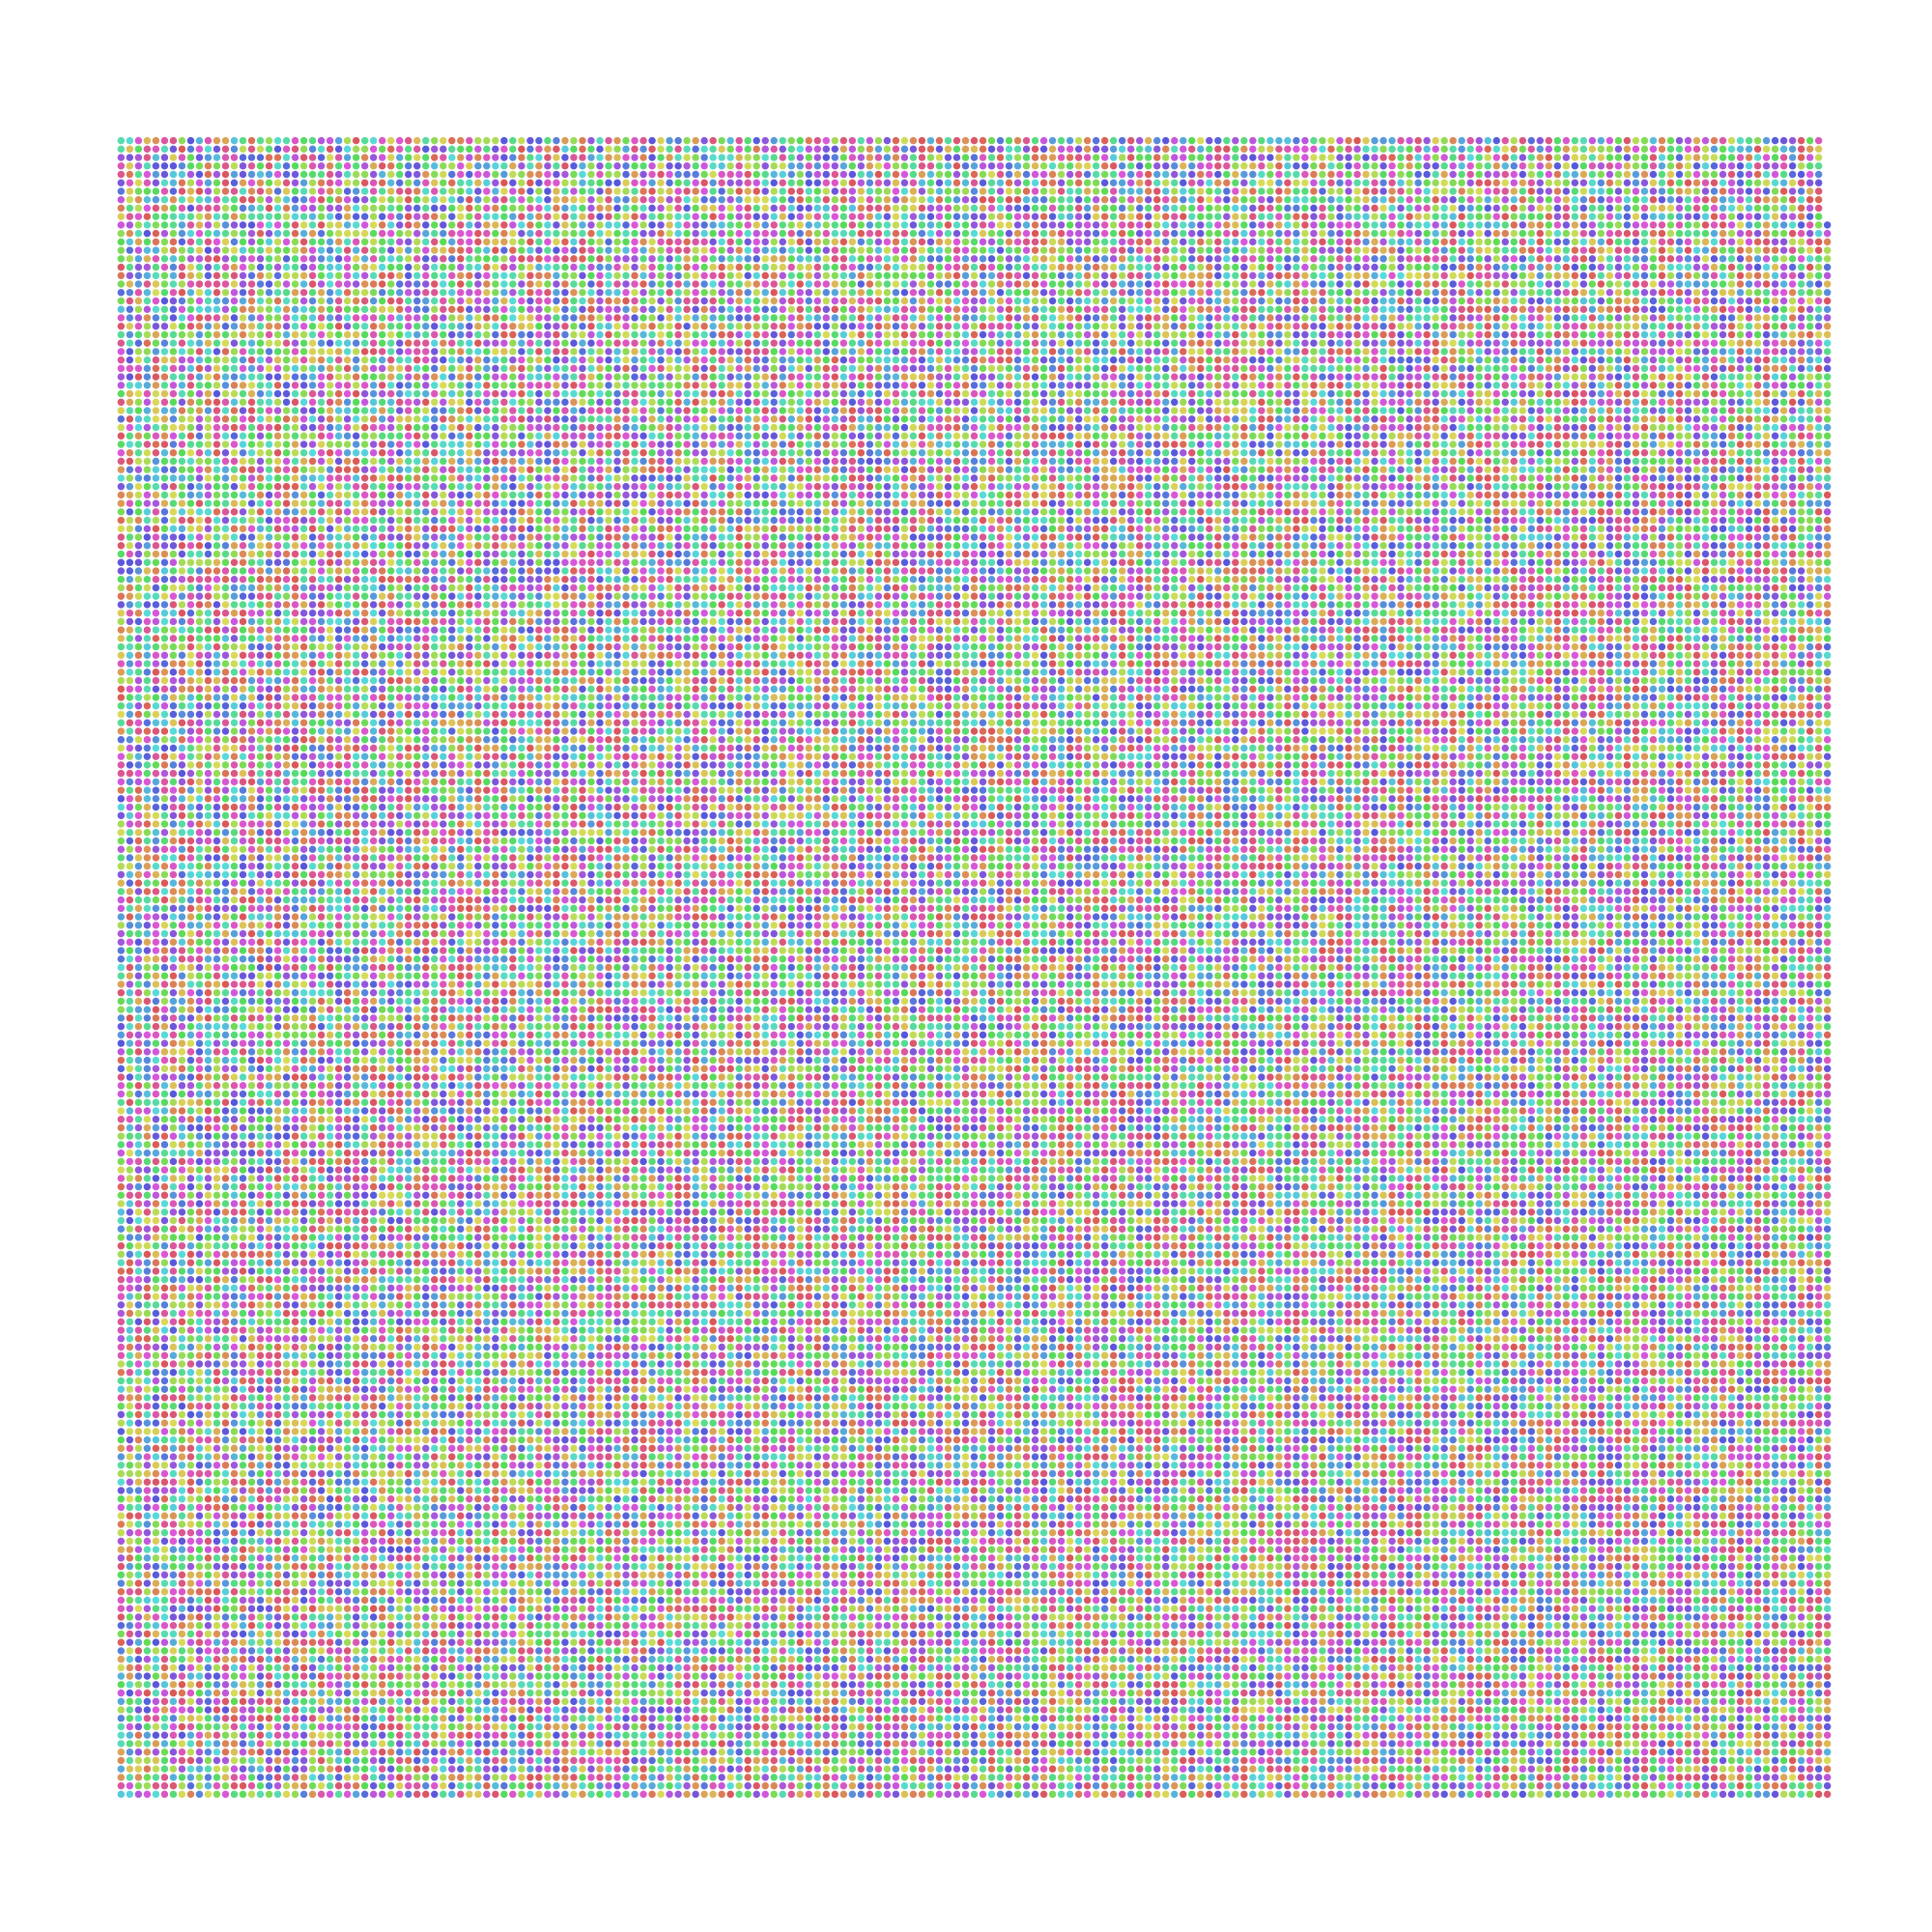

<Figure Size: (1000 x 1000)>

In [152]:
# Set random configurations
random_positions = make_random_configuration(filtered_data_matrix)

# Get a table of the positions for each bead ID (stored in the index)
initial_positions_df = position_matrix_to_df(random_positions)

plot_bead_proposal(random_positions)

## 2.2 TODO: Make and MDS layout as an initial guess for the data

In [73]:
from sklearn import manifold

# A dense matrix of 50K * 50K * 16 bits ~ 5GB
data_dense = filtered_data_matrix.todense()
data_dense = np.asarray(data_dense)
embedding = manifold.MDS(n_components=2, normalized_stress='auto')
beads_transformed = embedding.fit_transform(data_dense)
beads_transformed.shape


/Users/sanjay/Library/Python/3.11/lib/python/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


KeyboardInterrupt: 

# 3) Score a configuration
* A given model needs to have a certain score so that it can be compared to the data.
* One idea is to take a given euclidean configuration and to use some kind of a decay function around it (that we choose). We use this decay function (e.g. a gaussian), center it on a given bead, and multiply that decay times the edge weight as it hits each bead.
 
 1) Propose a solution
 2) For each bead, calculate a loss function
 3) Multiply the value of this gaussian times the edge weight of every other bead.
 4) Sum these values for every bead.
 5) Calculate a gradient for each bead
 6) Move beads along this gradient by some step size corresponding to the learning rate
 


$$
 \text{Score} = - \sum_{(i, j) \in \text{Edges}}  \left| \hat{y}_{ij} - y_{ij} \right|^\alpha \
$$

This is the most basic form of the score function where:
* $\hat{y}_{ij}$ is a function of the beads position in Euclidean layout 
* $y_{ij}$ is the observed data
* $\alpha$ denotes how steeply we are going to penalize or emphasize the difference between the euclidean representation $\hat{y}_{ij}$ and the data

When two beads are placed close to each other in space we want that to want to get a lower value for $\left| \hat{y}_{ij} - y_{ij} \right|$

$y_{ij}$ is going to be a positive value based on weight of an edge. This value probably needs to be normalized between all the edges in the graph in some way, but at the moment its minimum value is 0 or 1. \
When two beads are next to each other we want $\hat{y}_{ij}$ to be small. \
As two beads get further from each other we want $\hat{y}_{ij}$ to get large.


We can use something like $\frac{1}{x^2}$ to weight the distance between beads. This is kind of nice because the best distance between two beads at the moment is one. When beads are far apart, this value drops to be much smaller and as the beads get too close togehter the score will overshoot and increase the loss as well.

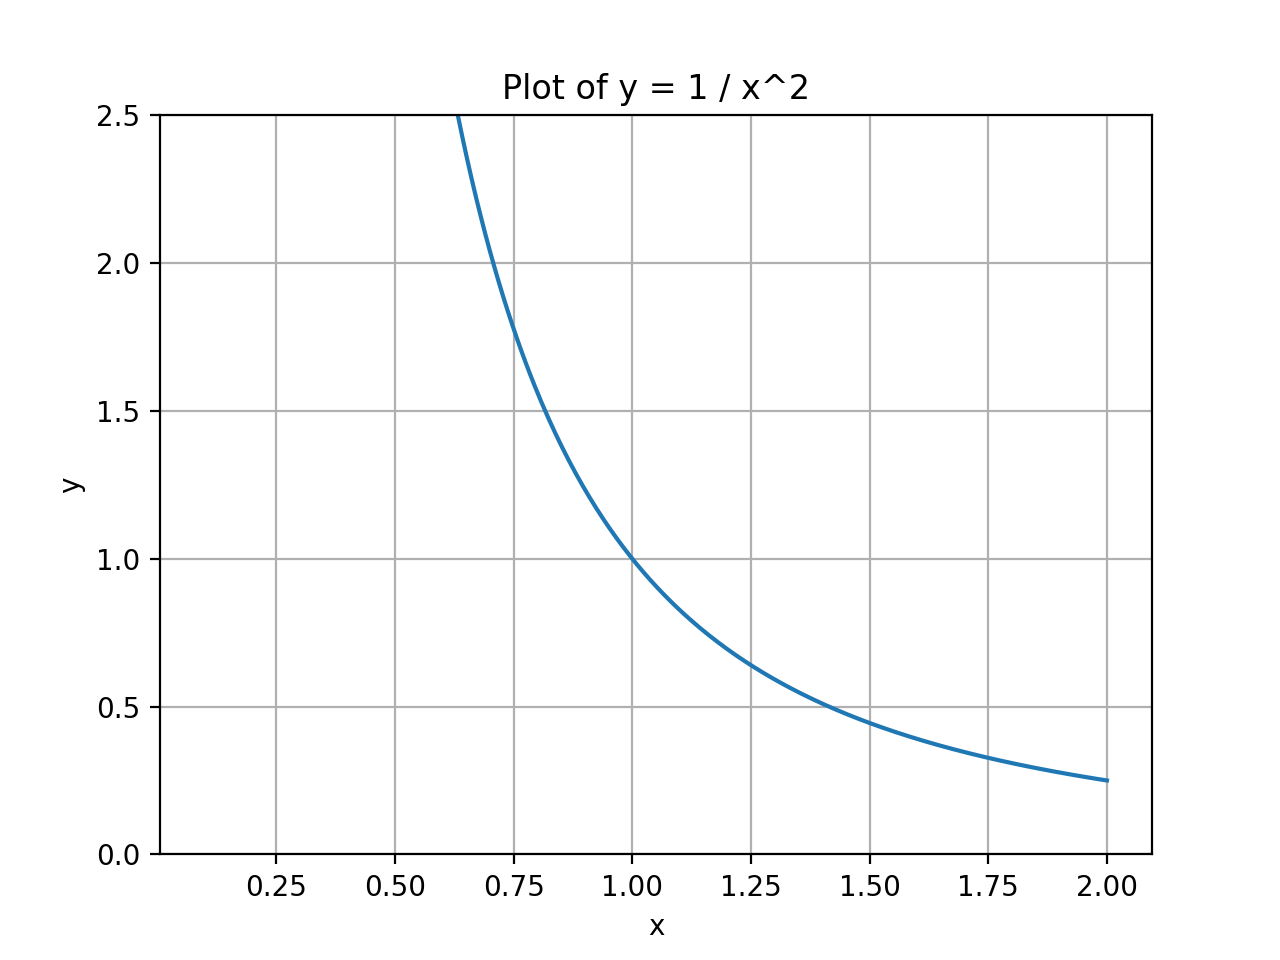

In [80]:
import matplotlib.pyplot as plt

# Define the function y = 1 / log(x)
def func(x):
    return 1/x**2

# Generate an array of x values from 0.1 to 2.0
x = np.linspace(0.1, 2.0, 400)

# Generate the y values based on the function
y = func(x)

# Create the plot
plt.plot(x, y)

# Set the title and labels
plt.title('Plot of y = 1 / x^2')
plt.xlabel('x')
plt.ylabel('y')
# Show the plot between 0 and 2.5 on the y axis
plt.ylim(0, 2.5)
# Show the plot
plt.grid(True)
plt.show()


$$
\text{Score} = - \sum_{(i, j) \in \text{Edges}} \left| \frac{{\beta}}{w_{ij}} - \text{dist}(B_i, B_j)^2  \right|^\alpha \
$$


/Users/sanjay/Library/Python/3.11/lib/python/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_x_log10 could not recognise parameter `lim`


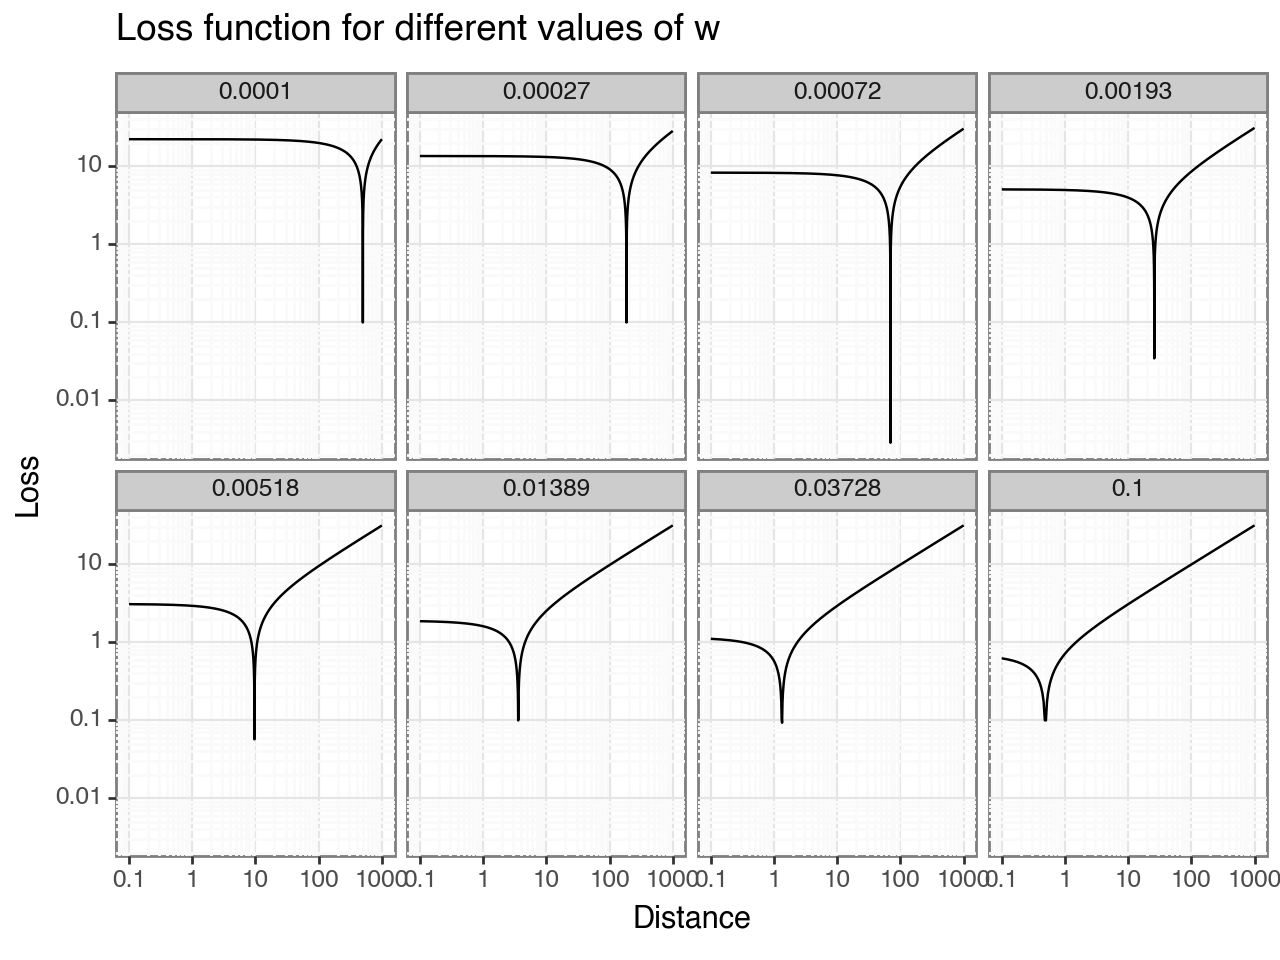

<Figure Size: (640 x 480)>

In [ ]:
x = np.linspace(0.1, 1000.0, 50000)

# Define the function y = 1 / x
def func(x, w, beta = .05, alpha = 2, epsilon = 0.01):
    
    return  np.abs(beta/(w) - (epsilon + x)) ** alpha 
 
# Generate the y values based on the function

w = np.logspace(-4,-1,8).round(5)
df = [pd.DataFrame({'x':x, 'y':func(x, w = w), 'w':w})for w in w]
#df_1 = pd.DataFrame({'x':x, 'y':func(x, w = 1), 'w':1})
    
#df_2 = pd.DataFrame({'x':x, 'y':func(x, w = .5), 'w':.5})
#df_3 = pd.DataFrame({'x':x, 'y':func(x, w = .10), 'w':.10})

df = pd.concat(df)

(ggplot(df, aes(x='x', y='y')) +
    geom_line() +
    theme(figure_size=(10,10),
          legend_position = 'none') +
          facet_wrap('w', ncol = 4) +
    scale_y_log10() + 
    scale_x_log10(lim = (0,1000)) +
    theme_bw() + 
    # set scale from 0 to 100
    #xlim(0, 1000) +
    xlab("Distance") +
    ylab("Loss") +
    ggtitle("Loss function for different values of w"))



In [153]:
# Sum the rows of this sparse matrix and divide each row by the sum
row_sums = filtered_data_matrix.sum(axis=1)
col_sums = filtered_data_matrix.sum(axis=0)

# Divide the matrix by the row sums
row_normalized_matrix = filtered_data_matrix / row_sums
col_normalized_matrix = filtered_data_matrix / col_sums

This has a couple nice characteristics. If we assume that the max weight of any edge is 1 (we can get this by rescaling the interaction matrix) and all other edge values are less than that we can basically have the maximum edge beads contribute the most to the loss. We can amplify this further by mutiplying by the edge weight or squaring the edge weight.


## JAX define our score function


In [154]:
#%pip install jax jaxlib
import jax
import jax.numpy as jnp


In [155]:
row_normalized_data = normalize_matrix(filtered_data_matrix, rows=True, cols=True)
tupple_data = graph_to_tupple(row_normalized_data)
print(f'There are {len(tupple_data)} edges in this graph')
print(f'The data is in a row, col, value format')
print(f'The first 3 edges are {tupple_data[:3]}')

position_df = position_matrix_to_df(random_positions)



There are 8597479 edges in this graph
The data is in a row, col, value format
The first 3 edges are [(0, 68, 0.0007126293197735169), (0, 135, 0.001497492862353318), (0, 167, 0.006470506873383318)]


,X,Y
ID,,
0,45,68
1,192,134
2,141,158
3,7,117
4,111,148
...,...,...
38794,176,14
38795,177,153
38796,176,51


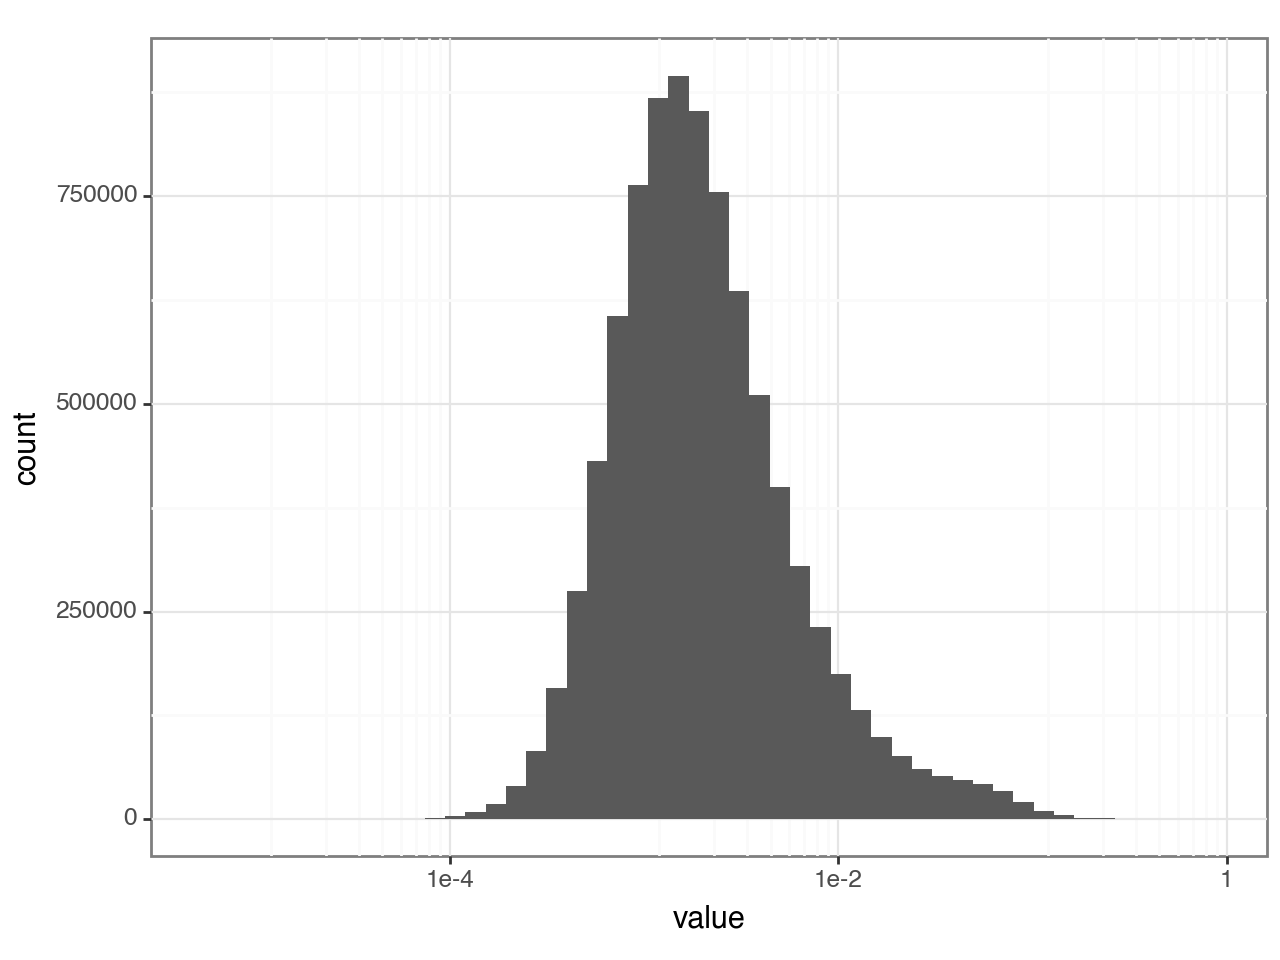

<Figure Size: (640 x 480)>

In [157]:

# Convert a list of tuples to a pandas dataframe
df = pd.DataFrame(tupple_data, columns = ['row', 'col', 'value'])
# Plot the distribution of the values
(ggplot(df, aes(x='value')) +
    geom_histogram(bins = 50) +
    theme(figure_size=(10,10),
          legend_position = 'none') +
    scale_x_log10() + 
    theme_bw())

In [173]:
def score_function(points, edges, alpha = 2, beta = 1):
    # Reshape params into points
    
    
    # Initialize the total score
    total_score = 0.0
    scores = []

    # Loop over all edges to calculate the score contribution of each edge
    for (b1, b2, w) in edges:
        # Compute the distance between points B_i and B_j
        dist = jnp.linalg.norm(points[b1] - points[b2])
        # np.abs(beta/(w) - (epsilon + x)) ** alpha 
        # Compute the score for this edge
        score = jnp.abs( beta / w -  dist) ** alpha

        # Add to the total score
        total_score += score
        scores.append(score)
    
    # Return the negative of the sum (since we're minimizing)
    return (-total_score,scores)


In [165]:
points =position_df[['X', 'Y']].to_numpy().reshape(-1, 2)
total_loss, score_dist = score_function(points, tupple_data)

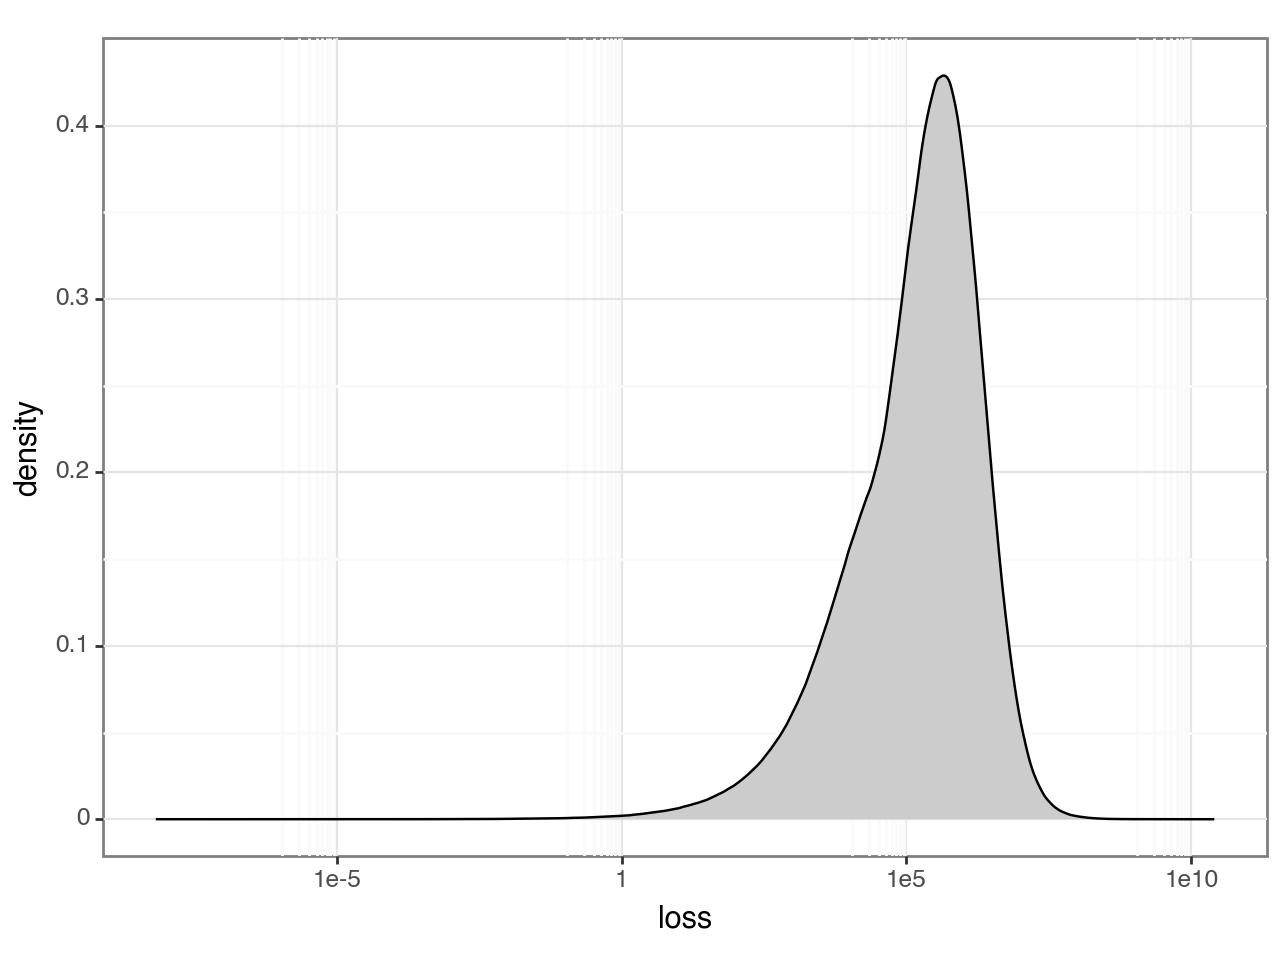

<Figure Size: (640 x 480)>

In [170]:
loss_per_pair = pd.DataFrame({'loss':score_dist})
(ggplot(loss_per_pair, aes(x='loss')) +
    geom_density(color = "black",
                 fill = "#cccccc") +
    theme(figure_size=(10,10),
          legend_position = 'none') +
    scale_x_log10() + 
    theme_bw())

## Compute the gradient of the score function

# Initialize the parameters

In [174]:
grad_score_function = jax.grad(score_function)


## Perform Gradient Descent Loop

In [175]:
alpha = 1e-1  # Learning rate
num_iterations = 1000  # Or some other stopping criterion
for i in range(num_iterations):
    gradients = grad_score_function(position_df)
    points = points - alpha * gradients
    
    # Optionally, you can compute the score here to monitor progress
    current_score = score_function(points)
    print(f'Iteration {i}, Score: {current_score}')
    
    # Include a convergence criterion to break the loop if necessary
    if jnp.linalg.norm(gradients) < tolerance:
        break


TypeError: Argument '         X    Y
ID             
0       45   68
1      192  134
2      141  158
3        7  117
4      111  148
...    ...  ...
38794  176   14
38795  177  153
38796  176   51
38797   77   77
38798  189  135

[38799 rows x 2 columns]' of type <class 'pandas.core.frame.DataFrame'> is not a valid JAX type.